In [1]:
from __future__ import print_function
from __future__ import division
import sys
import torch
import os
import tqdm
import pdb
import numpy as np
import platform
import hashlib
import pytorch_transformer
import re
import argparse
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from transformProtein import transformProtein
from ProteinDataset import ProteinDataset
from torch.utils.data import Dataset, DataLoader
import pickle

2023-07-16 21:12:15.876454: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-16 21:12:40.557461: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
use_py3 = platform.python_version()[0] == '3'

parser = argparse.ArgumentParser(description='PyTorch code for generating from CTRL')

#parser.add_argument('--model_dir', type =str, default='model_v0.pth', help='location of training model checkpoint')
#parser.add_argument('--model_path', type=str, default='/home/amadani/ctrl/ckpt/seqlen256_36layers_v0.ckpt/model.ckpt-684000', help='location of model *data* checkpoint to load; this is NOT the directory but rather the model checkpoint')

parser.add_argument('--model_dir', type =str, default='./checkpoints_cur/finetune_progen_full_demo.pth', help='location of training model checkpoint')
parser.add_argument('--model_path', type=str, default='../checkpoints/pretrain_progen_full.pth', help='location of model *data* checkpoint to load; this is NOT the directory but rather the model checkpoint')

parser.add_argument('--seed', type=int, default=313,
                                        help='random seed for PyTorch, numpy and PythonHash')
parser.add_argument('--sequence_len', type=int, default=511*1,
                                        help='sequence len of model being fine-tuned')
parser.add_argument('--num_epochs', type=int, default=1500, help='number of epochs to train for')
parser.add_argument('--num_layers', type=int, default=36, help='number of transfomer layers. used for loading checkpoint')
parser.add_argument('--batch_size', type=int, default = 4*2, help='batch size for dataloader')
parser.add_argument('--vocab_loc', type=str, default='mapping_files/vocab.txt', help='vocab location')
parser.add_argument('--num_workers', type=int, default=0, help='for dataloader')
parser.add_argument('--warmup_iteration', type=int, default=1000, help='LR warmup cutoff')
parser.add_argument('--save_iter', type=int, default=1000, help='save model checkpoint every X iterations')

args = parser.parse_args("")

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)
os.environ['PYTHONHASHSEED'] = str(args.seed)
np.random.seed(args.seed)

In [4]:
CUDA_DEVICE_NUM = 0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda:0


In [5]:
# load the vocabulary from file
vocab = open(args.vocab_loc).readlines() if not use_py3 else open(args.vocab_loc, encoding='utf-8').read().split('\n')[:-1]
vocab = list(map(lambda x: x.split(' ')[0], vocab))
# length of the vocabulary
vocab_size = len(vocab)
print('-----vocab size',vocab_size,'------')

# define the numericalization map
# idx2word maps the numericalized ID to the word
# word2idx maps the word to the numericalized ID
#word2idx = {u:i for i, u in enumerate(vocab)}
#idx2word = np.array(vocab)

# sequence length to use for transfomer
seq_length = args.sequence_len
embedding_dim = 1280

-----vocab size 129407 ------


In [6]:
class TiedEmbeddingSoftmax(torch.nn.Module):

  def __init__(self, vocab_size=vocab_size, embedding_size=embedding_dim, **kwargs):
    super(TiedEmbeddingSoftmax, self).__init__()
    self.w = torch.nn.Parameter(torch.normal(0., 1e-2, size=(vocab_size, embedding_size)))
    self.b = torch.nn.Parameter(torch.zeros(vocab_size))

  def forward(self, inputs, embed=True):
    if embed:
      return torch.nn.functional.embedding(inputs, self.w)
    else:
      return torch.tensordot(inputs, self.w.t(), 1) + self.b

class CTRLmodel(torch.nn.Module):
  def __init__(self):
    super(CTRLmodel,self).__init__()
    self.tied_embedding_softmax = TiedEmbeddingSoftmax()
    self.encoder = pytorch_transformer.Encoder(device=DEVICE)

  def forward(self, inputs):
    x = self.tied_embedding_softmax(inputs, embed = True)
    x = self.encoder(x)
    x = self.tied_embedding_softmax(x, embed = False)
    return x

  def loadCheckpoint(self, model_path, num_layers):
    #pytorch_model_hash = hashlib.md5(model_path.encode('utf-8')).hexdigest()
    pytorch_model_hash = model_path

    if os.path.exists(pytorch_model_hash):
      print('Found PyTorch checkpoint @', pytorch_model_hash)
      print('Loading instead of converting from TensorFlow')
      checkpoint = torch.load(pytorch_model_hash)
      
      #self.tied_embedding_softmax.load_state_dict(checkpoint['softmax'])
      #self.encoder.load_state_dict(checkpoint['encoder'])
      ## load state dict has KeyError, because checkpoint is ready the state_dict
      ## can load checkpoint directly 
      ## https://discuss.pytorch.org/t/keyerror-state-dict/18220/5
      self.load_state_dict(checkpoint)

      #self.tied_embedding_softmax.to('cuda')
      #self.encoder.to('cuda')
      self.tied_embedding_softmax.to(DEVICE)
      self.encoder.to(DEVICE)
      #self.tied_embedding_softmax.cuda()
      #self.encoder.cuda()

    else:
      print('Error: Could not find PyTorch checkpoint')
      sys.exit(1)

In [7]:
# initialize ctrl object
model = CTRLmodel()
print('model initialized')

model initialized


In [8]:
# load checkpoint with args.model_path
model.loadCheckpoint(model_path=args.model_path, num_layers = args.num_layers)
print('previous checkpoint loaded')
#model = model.cuda()
model = model.to(DEVICE)

Found PyTorch checkpoint @ ../checkpoints/pretrain_progen_full.pth
Loading instead of converting from TensorFlow
previous checkpoint loaded


In [9]:
# freeze all weights except embedding
for p in model.parameters():
    p.requires_grad=False
model.tied_embedding_softmax.w.requires_grad=True
model.tied_embedding_softmax.b.requires_grad=True

In [10]:
# Create a DataParallel model
# if torch.cuda.device_count() > 1:
#     model = torch.nn.DataParallel(model)
#     model = model.cuda()

In [11]:
class Trainer(object):
    def __init__(self, model, warmup_iteration, seq_length, batch_size, num_workers, vocab_size, model_dir, save_iter, pklpath):
        self.model = model
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.vocab_size = vocab_size
        self.model_dir = model_dir
        self.save_iter = save_iter
        self.pklpath = pklpath
        self.firstAAidx = self.vocab_size - 26 # Assuming that the pad token is the last token and AAs are at the end
        
        self.optimizer = torch.optim.Adam(self.model.parameters()) #lr, betas
        lambdafn = lambda iteration: min(iteration/(warmup_iteration*1.0),1.0)
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lambdafn)
        
        self.criterion = torch.nn.CrossEntropyLoss(ignore_index=self.vocab_size-1, reduction='none')
        
        self.transformFull = transformProtein(maxSampleLength = seq_length+1, 
                                              selectSwiss = 1.0, selectTrembl = 0, 
                                              maxTaxaPerSample = 3, maxKwPerSample = 5, dropRate = 0.2)
        self.transformPartial = transformProtein(maxSampleLength = seq_length+1,   
                                                 selectSwiss = 1.0, selectTrembl = 0,
                                                 maxTaxaPerSample = 3, maxKwPerSample = 5, dropRate = 0.2)
        self.transformNone = transformProtein(maxSampleLength = seq_length+1,   
                                              selectSwiss = 1.0, selectTrembl = 0,
                                              maxTaxaPerSample = 3, maxKwPerSample = 5, dropRate = 0.2)
        
        self.writer = SummaryWriter()

    def train(self, num_epochs):
        self.model.train()

        iter_num = 0
        for epoch in range(num_epochs):
            loss_e = 0.0
            num_e = 0

            for chunknum in range(1):
                #pklpath = '../miBIG/mibig_train_new2.p'
                #pklpath = '../miBIG/mibig_train_new.p'
                chunk_dataset = ProteinDataset(self.pklpath, firstAAidx = self.firstAAidx, transformFull = self.transformFull, 
                                               transformPartial = self.transformPartial, transformNone = self.transformNone)
                dataloader = DataLoader(chunk_dataset, shuffle = True, batch_size = self.batch_size,
                                        num_workers = self.num_workers, pin_memory = False) #TODO pinmem?
                
                for i, (sample, labels, existence, padIndex, begAAindex) in enumerate(dataloader):
                    self.optimizer.zero_grad()
                    #sample, labels, existence, padIndex = sample.cuda(), labels.cuda(), existence.cuda(), padIndex.cuda()
                    sample, labels, existence, padIndex = sample.to(DEVICE), labels.to(DEVICE), existence.to(DEVICE), padIndex.to(DEVICE)
                    output = self.model(sample)
                    #pdb.set_trace()
                    loss = self.criterion(output.permute(0,2,1), labels)
                    loss = torch.mean((torch.sum(loss,dim=1)/padIndex)*existence) #pad masking, loss weighting
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.25)
                    self.optimizer.step()
                    self.scheduler.step()
                    loss_e += loss.item()
                    num_e += sample.shape[0]
                    iter_num += 1
                    self.writer.add_scalar('Loss_iteration',loss.item(),iter_num)

                    if (iter_num+1)%self.save_iter==0 or (epoch+1==num_epochs):
                        torch.save({'epoch': epoch, 'chunknum': chunknum, 'iteration':iter_num,
                                    'model_state_dict': self.model.state_dict(),
                                    'optimizer_state_dict': self.optimizer.state_dict(),
                                    'loss': loss,
                                   }, self.model_dir)
                loss_e/=num_e
            print("Epoch: {0} ; loss_e: {1}".format(epoch, loss_e))
            self.writer.add_scalar('Loss_epoch',loss_e, epoch)

## BGC training samples on S3:
`aws s3 ls s3://share.jgi-ga.org/satria/for_bgc_gpt/ --recursive`

In [105]:
import json
import pickle
import pandas as pd

# Read JSON data from file
with open('../miBIG/S3/data-1.json', 'r') as json_file:
    json_data = json.load(json_file)

json_dict = {}
for k in range(len(json_data[:])):
    d = json_data[k]
    d['seq'] = d['seq'].replace(' ', 'B')
    list(d['swiss'].keys())[0]
    uid = 'BGC' + list(d['swiss'].keys())[0] + '-' + str(k)
    d['swiss'] = dict(zip([uid], d['swiss'].values()))
    json_dict[uid] = d

In [106]:
json_dict['BGC82598-0']

{'swiss': {'BGC82598-0': {'ex': 1,
   'kw': ['GCF-244878', 'RiPP/bacteriocin'],
   'taxa': []}},
 'seq': 'MNGKRNIFTCISIIGIGLASFSSFSFAANVTDNSVQNSIPVVNQQVAAAKEMKPFPQQVNYAGVIKPTHVTQESLNASVRSYYDNWKKKYLKNDLSSLPGGYYVKGEITGDADGFKPLGTSEGQGYGMIITVLMAGYDSNAQKIYDGLFKTARTFKSSQNPNLMGWVVADSKKAQGHFDSATDGDLDIAYSLLLAHKQWGSNGTVNYLKEAQDMITKGIKASNVTNNSRLNLGDWDSKNSLDTRPSDWMMSHLRAFYEFTGDKTWLTVINNLYDVYTQFSNKYSPNTGLISDFVVKNPPQPAPKDFLEESEYTNAYYYNASRVPLRIVMDYAMYGEKRSKVISDKVSSWIQNKTNGNPSKIVDGYQLNGSNIGSYSTAVFVSPFIAASITSSNNQKWVNSGWDWMKNKRESYFSDSYNLLTMLFITGNWWKPVPDDKKIQNQINDAIYEGYDNBMEKVLFFGDPGIDDSFAIMYGLLHPEIEIVGIVTGYGNVEHIHAAHNAAYILQLANRQ'}

In [107]:
vocab_df = pd.read_csv('mapping_files/vocab.txt', sep=' ',header=None)
vocab_df.columns = ['key','value']
vocab_df

,key,value
0,472,0
1,812,1
2,1133,2
3,808,3
4,175,4
...,...,...
129402,W,129402
129403,X,129403
129404,Y,129404
129405,Z,129405


In [108]:
kw = [json_dict[uid]['swiss'][uid]['kw'] for uid in json_dict.keys()]
kw_types = np.unique([k[0] for k in kw])
kw_types

array(['GCF-244878', 'GCF-245373', 'GCF-245671', 'GCF-245936',
       'GCF-246515', 'GCF-247890'], dtype='<U10')

In [109]:
kw_map = dict(zip(kw_types, vocab_df['key'][:len(kw_types)]))
kw_map

{'GCF-244878': '472',
 'GCF-245373': '812',
 'GCF-245671': '1133',
 'GCF-245936': '808',
 'GCF-246515': '175',
 'GCF-247890': '732'}

In [110]:
for uid in json_dict.keys():
    json_dict[uid]['swiss'][uid]['taxa'] = [9606] # homo sapiens taxonomy id from NCBI: https://www.ncbi.nlm.nih.gov/taxonomy
    kw_tmp = json_dict[uid]['swiss'][uid]['kw']
    json_dict[uid]['swiss'][uid]['kw'] = [kw_map[kw_tmp[0]]]

In [111]:
json_dict['BGC82598-0']

{'swiss': {'BGC82598-0': {'ex': 1, 'kw': ['472'], 'taxa': [9606]}},
 'seq': 'MNGKRNIFTCISIIGIGLASFSSFSFAANVTDNSVQNSIPVVNQQVAAAKEMKPFPQQVNYAGVIKPTHVTQESLNASVRSYYDNWKKKYLKNDLSSLPGGYYVKGEITGDADGFKPLGTSEGQGYGMIITVLMAGYDSNAQKIYDGLFKTARTFKSSQNPNLMGWVVADSKKAQGHFDSATDGDLDIAYSLLLAHKQWGSNGTVNYLKEAQDMITKGIKASNVTNNSRLNLGDWDSKNSLDTRPSDWMMSHLRAFYEFTGDKTWLTVINNLYDVYTQFSNKYSPNTGLISDFVVKNPPQPAPKDFLEESEYTNAYYYNASRVPLRIVMDYAMYGEKRSKVISDKVSSWIQNKTNGNPSKIVDGYQLNGSNIGSYSTAVFVSPFIAASITSSNNQKWVNSGWDWMKNKRESYFSDSYNLLTMLFITGNWWKPVPDDKKIQNQINDAIYEGYDNBMEKVLFFGDPGIDDSFAIMYGLLHPEIEIVGIVTGYGNVEHIHAAHNAAYILQLANRQ'}

In [98]:
# Convert Python object to pickle
with open('../miBIG/S3_pickle/data-1.pickle', 'wb') as pickle_file:
    pickle.dump(json_dict, pickle_file)

Using one unified encoder to represent protein sample with length 129406
training data size: 6650


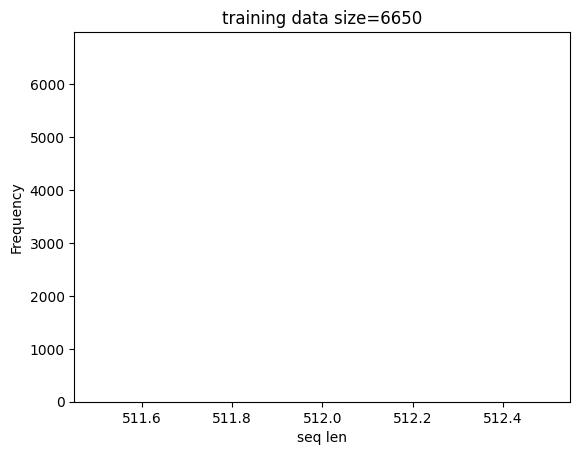

In [90]:
##########################################################
# Check the format of training data before the model train
##########################################################
pklpath = '../miBIG/S3_pickle/data-1.pickle'
#pklpath = '../miBIG/mibig_train_new3.p'  # size=100
#pklpath = '../miBIG/mibig_train_new2.p' # size=60
#pklpath = '../miBIG/mibig_train_new.p'  # size=49
#pklpath = '../miBIG/mibig_train.p'      # size=60 with format error

obj = transformProtein(mapfold = "./mapping_files", selectSwiss = 1.0, selectTrembl = 0, maxTaxaPerSample = 3, maxKwPerSample = 5, dropRate = 0.2)
with open(pklpath, 'rb') as handle:
    train_chunk = pickle.load(handle)

    error_uid = []
for uid in train_chunk.keys():
  try:
    sample_arr, existence, thePadIndex = obj.transformSample(train_chunk[uid])
    #print("loaded UID:", uid)
  except:
    error_uid.append(uid)
    print("Error UID:", uid)
    print(train_chunk[uid])

for uid in error_uid:
    train_chunk.pop(uid)
    print("Removed UID:", uid)
    
print("training data size:", len(train_chunk))

import matplotlib.pyplot as plt
train_seq_len = [len(train_chunk[k]['seq'])for k in train_chunk]
plt.hist(np.array(train_seq_len), bins=len(train_chunk))
plt.xlabel('seq len')
plt.ylabel('Frequency')
plt.title('training data size={}'.format(len(train_chunk)))
plt.show()

In [6]:
train_chunk['BGC0001135']

{'swiss': {'BGC0001135': {'ex': 1, 'kw': ['NRP'], 'taxa': [290110]}},
 'seq': 'MTELDRAFDAVPAPIYTHHERHGETVHRSAPESIRRELAALQVRAGDRVLEIGTGSGYSGALLAHLCCPDGQVTSIDISDELVRRAAAIHAERGVTSVDCHVGDGLAGYPAAAPFHRAVSWCAPPRLPRAWTQQVVNGGRIVACLPITALPSTTLIATITVAAGKPRIEALAGGGYAQSTPVAVDDALTVPGRWVDYCDRQPDPSWIGICWRSADDAQHTGARSALGQLLHPGYTDTYRQMEPHWRSWYTWTSALGDPQLSLVSLRNEIRGLGHTTPSSAAVILTDGRVIADRPDSPSLRSLRTWLQRWEHVGRPAPESFARTLVPHDCPDLAGWDLQVGHGSVTTDRQPPRRVDEPRRP'}

In [14]:
print(f"warmup_iteration = {args.warmup_iteration},\
\nseq_length = {seq_length}, \
\nbatch_size = {args.batch_size}, \
\nnum_workers = {args.num_workers}, \
\nvocab_size = {vocab_size}, \
\nmodel_dir = {args.model_dir}, \
\nsave_iter = {args.save_iter},\
\npklpath = {pklpath}")

warmup_iteration = 1000,
seq_length = 511, 
batch_size = 8, 
num_workers = 0, 
vocab_size = 129407, 
model_dir = ./checkpoints_cur/finetune_progen_full_demo.pth, 
save_iter = 1000,
pklpath = ../miBIG/S3_pickle/data-1.pickle


In [ ]:
##########################################################
# Train the model
##########################################################
import time
training = Trainer(model=model, warmup_iteration=args.warmup_iteration, seq_length=seq_length,
                   batch_size=args.batch_size, num_workers=args.num_workers, vocab_size=vocab_size,
                   model_dir = args.model_dir, save_iter=args.save_iter,
                   pklpath=pklpath)
print('begin training...')
start_time = time.time()  # Start time of the training
training.train(args.num_epochs)
end_time = time.time()  # End time of the training

Using one unified encoder to represent protein sample with length 129406
Using one unified encoder to represent protein sample with length 129406
Using one unified encoder to represent protein sample with length 129406
begin training...
Epoch: 0 ; loss_e: 0.706354321429604
Epoch: 1 ; loss_e: 0.693211723198568
Epoch: 2 ; loss_e: 0.690195220789515
Epoch: 3 ; loss_e: 0.6884701750332252
Epoch: 27 ; loss_e: 0.6852325250152358


In [ ]:
elapsed_time = end_time - start_time  # Calculate the traiing time
print(f"Elapsed time: {round(elapsed_time)} seconds")